In [1]:
import pandas as pd

import os
import pickle as pkl
from urllib.request import urlretrieve

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

from IPython.display import Image, display, clear_output

import pandas as pd
import sentencepiece as spm

# Load data

In [2]:

train_formal_file = 'GYAFC_Corpus/Family_Relationships/train/formal'
train_informal_file = 'GYAFC_Corpus/Family_Relationships/train/informal'

In [3]:
with open(train_formal_file) as f:
    formal = [line.rstrip() for line in f]
    
with open(train_informal_file) as f:
    informal = [line.rstrip() for line in f]

In [4]:
train_df = pd.DataFrame({'Formal': formal, 'Informal': informal})
train_df

,Formal,Informal
0,I prefer to let the guy ask me.,"Sure, it's ok, but I always have let the guy a..."
1,I suffer through verbal abuse from my wife.,"Hmmm, I'm a guy suffering from verbal abuse fr..."
2,You will have more friends than you want.,You will have more friends that you want... ;)
3,It's nice that you get to see pictures of who ...,"It's nice, you get to see pictures of who you ..."
4,I need to know what to do.,I NEED TO KNOW WHAT 2 DO
...,...,...
51962,"Of course, it depends on what type of relation...",of corse it depends on what relation u r looki...
51963,"Wear a sign that say ""Hi!""",Wear a sign that says Hi!
51964,I do not like when guys play games with me.,"I don't believe in playing games, I hate when ..."
51965,How old are you?,(or w/e) p.s gurl how old r u ?


In [5]:
for _, row in train_df.sample(n=10).iterrows():
    print(f"Formal: {row.Formal}\nInformal: {row.Informal}\n")

Formal: I hope that helps, and best of luck because you are always the most important person in your life!
Informal: Hope that helps, and good luck because you are always the most important person first in your life!!!

Formal: Hint at it first but if he does not understand then tell him clearly.
Informal: hint at it then if they dont get it just come out and tell them

Formal: Before you assume that she is cheating, do some investigation.
Informal: YOU NEED TO DO SOME INVESTIGATING BEFORE YOU ASSUME THAT SHE IS CHEATING.

Formal: Perhaps what you desire most is what you do not have.
Informal: I think you might just love what your not getting.

Formal: I am a girl, I am in this situation.
Informal: i'm a girl i'm in this situation

Formal: Does he truly like me, or, does he like to flirt?
Informal: Does he like me or does he just like flirt?

Formal: You must admit that, after all, a girl needs to eat.
Informal: After all, a girl's got to eat.

Formal: You should spend a lot of time wi

# Pre-process text

In [6]:

root = os.getcwd()
informalPath = os.path.join(root,'GYAFC_Corpus','Family_Relationships','train','informal')
formalPath = os.path.join(root,'GYAFC_Corpus','Family_Relationships','train','formal')
print(root)
print(informalPath)
informalTrain = pd.read_csv(informalPath,sep = '\n', header = None)
informalTrain.head()

spm.SentencePieceTrainer.train('--input=' + informalPath + ' --model_prefix=m --vocab_size=10000 --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS], --normalization_rule_name=nfkc_cf')
sp = spm.SentencePieceProcessor()
sp.Load('m.model')

/home/mathias/Dropbox/Uni/Deeplearning/Project
/home/mathias/Dropbox/Uni/Deeplearning/Project/GYAFC_Corpus/Family_Relationships/train/informal


True

In [7]:
print('bos=', sp.bos_id())
print('eos=', sp.eos_id())
print('unk=', sp.unk_id())
print('pad=', sp.pad_id())

bos= 2
eos= 3
unk= 1
pad= 0


In [8]:
tokenized_formal = np.array([sp.encode_as_ids(line) for line in formal])
tokenized_informal = np.array([sp.encode_as_ids(line) for line in informal])

In [9]:
print(sp.decode_ids(tokenized_formal[0]))

i prefer to let the guy ask me.


# Figuring out where to cut sentence lenghts

In [10]:
tokenized_lens_formal = np.array([len(element) for element in tokenized_formal])
tokenized_lens_informal = np.array([len(element) for element in tokenized_informal])
print(f"Longest formal sequence: {tokenized_lens_formal.max()}")
print(f"Longest informal sequence: {tokenized_lens_informal.max()}")

Longest formal sequence: 56
Longest informal sequence: 45


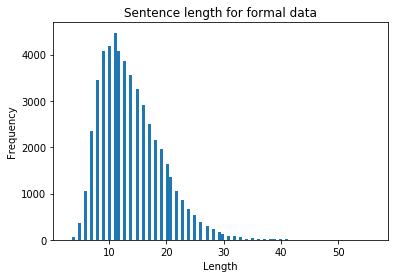

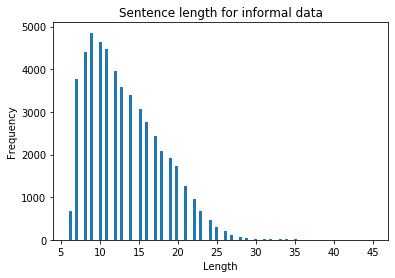

In [11]:
# Plot histogram

import matplotlib.pyplot as plt

pd.Series(tokenized_lens_formal).plot(kind='hist', bins=100)
plt.title('Sentence length for formal data')
plt.xlabel('Length')
plt.show()
pd.Series(tokenized_lens_informal).plot(kind='hist', bins=100)
plt.title('Sentence length for informal data')
plt.xlabel('Length')
plt.show()

# Cutting sentences to set length

In [12]:
sub_tokenized_formal = tokenized_formal[((tokenized_lens_formal <= 30) & (tokenized_lens_informal <= 30))]
sub_tokenized_informal = tokenized_informal[((tokenized_lens_formal <= 30) & (tokenized_lens_informal <= 30))]
sub_formal = np.array(formal)[((tokenized_lens_formal <= 30) & (tokenized_lens_informal <= 30))]
sub_informal = np.array(informal)[((tokenized_lens_formal <= 30) & (tokenized_lens_informal <= 30))]

In [13]:
sub_tokenized_formal.size

51514

In [14]:
sub_tokenized_informal.size

51514

In [15]:
train_df = pd.DataFrame({'Formal': sub_formal, 'Informal': sub_informal})
train_df

,Formal,Informal
0,I prefer to let the guy ask me.,"Sure, it's ok, but I always have let the guy a..."
1,I suffer through verbal abuse from my wife.,"Hmmm, I'm a guy suffering from verbal abuse fr..."
2,You will have more friends than you want.,You will have more friends that you want... ;)
3,It's nice that you get to see pictures of who ...,"It's nice, you get to see pictures of who you ..."
4,I need to know what to do.,I NEED TO KNOW WHAT 2 DO
...,...,...
51509,"Of course, it depends on what type of relation...",of corse it depends on what relation u r looki...
51510,"Wear a sign that say ""Hi!""",Wear a sign that says Hi!
51511,I do not like when guys play games with me.,"I don't believe in playing games, I hate when ..."
51512,How old are you?,(or w/e) p.s gurl how old r u ?


Longest formal sequence: 30
Longest informal sequence: 30


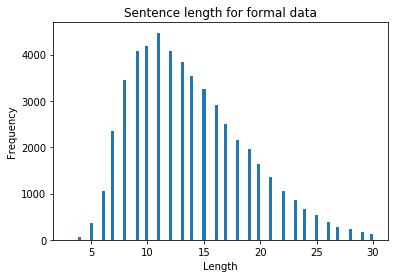

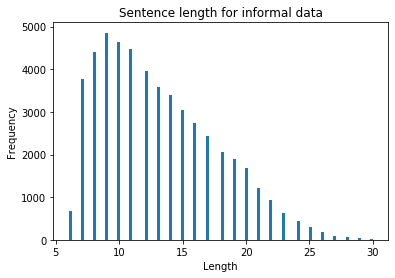

In [16]:
# Plot histogram
sub_tokenized_lens_formal = np.array([len(element) for element in sub_tokenized_formal])
sub_tokenized_lens_informal = np.array([len(element) for element in sub_tokenized_informal])
print(f"Longest formal sequence: {sub_tokenized_lens_formal.max()}")
print(f"Longest informal sequence: {sub_tokenized_lens_informal.max()}")

pd.Series(sub_tokenized_lens_formal).plot(kind='hist', bins=100)
plt.title('Sentence length for formal data')
plt.xlabel('Length')
plt.show()
pd.Series(sub_tokenized_lens_informal).plot(kind='hist', bins=100)
plt.title('Sentence length for informal data')
plt.xlabel('Length')
plt.show()

# Padding sentences to same lenghts

In [19]:
def pad_token_array(array, padded_len):
    len_array = len(array)
    padding = (padded_len - len_array) * [0]
    return array + padding

In [22]:
sub_tokenized_formal

array([list([7, 669, 8, 132, 13, 61, 72, 42, 4]),
       list([7, 2380, 597, 5670, 1566, 149, 49, 234, 4]),
       list([5, 63, 32, 105, 101, 166, 5, 56, 4]), ...,
       list([7, 34, 24, 23, 76, 73, 394, 777, 25, 42, 4]),
       list([77, 212, 35, 5, 37]),
       list([16, 5, 447, 28, 6, 5, 182, 27, 10, 906, 8, 430, 43, 41, 187, 8, 34, 4])],
      dtype=object)

In [30]:
padded_sub_tokenized_formal = [pad_token_array(element, 30) for element in sub_tokenized_formal]
padded_sub_tokenized_informal = [pad_token_array(element, 30) for element in sub_tokenized_informal]

In [31]:
for x in padded_sub_tokenized_formal:
    assert len(x) == 30
    
for x in padded_sub_tokenized_informal:
    assert len(x) == 30

In [32]:
padded_training_data = padded_sub_tokenized_formal

# Model

In [33]:
import torch
import torch.nn as nn

In [24]:
class RNN_VAE(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, latent_dim,vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        
        self.encoder_lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_sigma = nn.Linear(hidden_dim, latent_dim)
    
    
    def encode(self, sentence):
        embeds = self.word_embeddings(sentence)
        _, hidden_state = self.encoder_lstm(embeds.view(len(sentence), 1, -1))
        mu = self.linear_mu(hidden_state)
        sigma = self.linear_sigma(hidden_state)
        return 
    
    def reparameterize(self, mu, logvar): # Why do we use logvar? computational stability?
        sigma = torch.exp(logvar/2)
        eps = torch.rand_like(sigma)
        return mu + eps*sigma
    
    def decode(self, z, sentence):
        
        return
        
    def forward(self, sentence):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar